In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

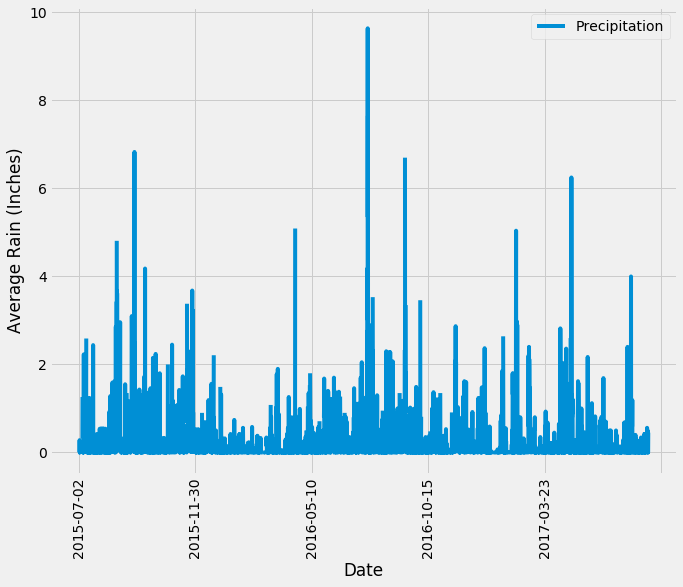

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = (session
             .query(Measurement.date)
             .order_by(Measurement.date.desc())
             .first()
            )
last_date
query_date = dt.datetime(2016, 6 ,30) - dt.timedelta(days=365)
query_date

# Perform a query to retrieve the data and precipitation scores
date_prcp = (session
             .query(Measurement.date, Measurement.prcp)
             .filter(func.strftime('%Y-%m-%d', Measurement.date) > query_date)
             .all()
            )

# Save the query results as a Pandas DataFrame and set the index to the date column
date_prcp_df = pd.DataFrame(date_prcp)
date_prcp_df = date_prcp_df.set_index('date')

# Sort the dataframe by date
date_prcp_df = date_prcp_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data

fig, ax = plt.subplots(figsize=(10,8))
date_prcp_df.plot(x_compat=True, ax=ax)
plt.xlabel("Date")
plt.ylabel("Average Rain (Inches)")
plt.xticks(rotation = 90)
plt.legend(["Precipitation"])

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(date_prcp_df.describe())

              prcp
count  4373.000000
mean      0.203933
std       0.521579
min       0.000000
25%       0.000000
50%       0.020000
75%       0.160000
max       9.640000


In [12]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).group_by(Station.station).count()
print(f'There are {station_count} stations.')

There are 9 stations.


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc())

for i in station_count:
    print(i)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
top_station = station_count.first()
top_station = top_station[0]

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == top_station).all()

[(54.0, 85.0, 71.66378066378067)]

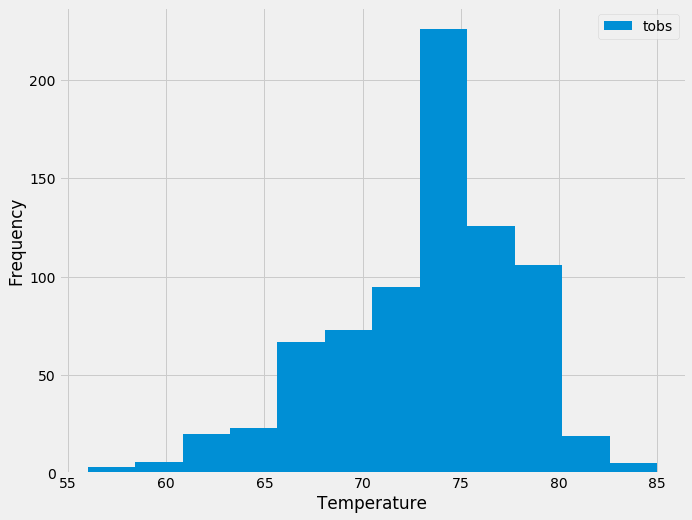

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_df = session.query(Measurement.date, Measurement.tobs).\
    filter(func.strftime('%Y-%m-%d', Measurement.date) > query_date).\
    filter(Measurement.station == station_count[0][0]).all()
temp_df = pd.DataFrame(temp_df)
fig, ax = plt.subplots(figsize=(10,8))
plt.hist(temp_df["tobs"],bins = 12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"])

## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-06-30', '2016-07-10'))

[(71.0, 77.0909090909091, 82.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
previous_year_trip = calc_temps('2015-06-30', '2015-07-10')
previous_year_trip

[(67.0, 76.85483870967742, 83.0)]

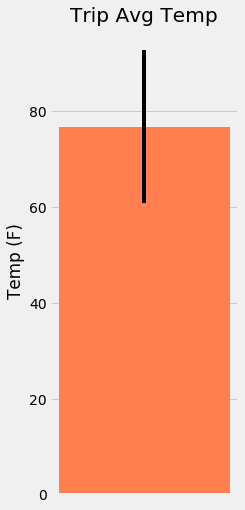

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,8))

plt.bar(x=1, y=0, yerr=previous_year_trip[0][2]-previous_year_trip[0][0], height=previous_year_trip[0][1], color = "coral", align='center')
plt.xticks([])
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.show()

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
total_rain = session.query(*sel).group_by(Station.name).filter(Measurement.date >= '2016-06-30').filter(Measurement.date <= '2017-06-10').\
    filter(Station.station == Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

total_rain

[('MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  157.39999999999992),
 ('WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  89.26000000000008),
 ('KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 60.73000000000004),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 44.82),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  32.60999999999999),
 ('WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 22.78000000000001),
 ('PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 5.1499999999999995)]

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("06-30")

[(67.0, 75.59615384615384, 81.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
